<a href="https://colab.research.google.com/github/eyv7jz/DS4001/blob/main/DS_4001_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Alzheimer's Disease Severity from MRIs
By: Brice Howe and Valyn Grebe

# Interest & Motivation


*   One of the top 10 leading causes of death with approx. half a million people being diagnosed and over 120,000 deaths per year in the U.S.
*   While no cure currently exists, early detection is crucial for improving overall quality of life by allowing for earlier intervention, better planning for the future, and access to potential treatment options and support services  that slow disease progression and manage symptoms
*   Difficult to diagnose but MRIs can show atrophied (shruken) parts of the brain to help identify abnormal brain function that may be considered dementia
*   Being able to classify the severity of dementia as well as whether or not a patient's scans present with it is important for effective management and treatment




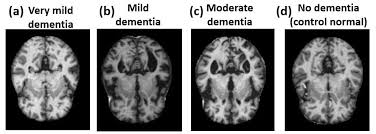

# Prior Research


*   Khalid et al. developed three methodologies to classifying and predict Alzheimer’s Disease with MRI images and found the Convolutional Neural Networks (CNNs) with handcrafted features to be the most accurate with an accuracy of 99.7%
*   Weiming et al. aimed to predict whether individuals with mild cognitive impairment would progress to Alzheimer’s using MRI images analyzed by a CNN model with FreeSurfer features, fed into an extreme learning machine classifier, achieving 79.9% accuracy
* Xiaojing et al. sought to predict Alzheimer’s disease progression by quantifying MRI deformation fields through symmetric diffeomorphic registration, extracting relevant features with an embedding algorithm, and classifying them using a support vector machine (SVM), which achieved a 96.5% accuracy



# Final Question:
Can MRI images be used to accurately classify different stages of cognitive impairment (Non-demented, Very Mild Demented, Mild Demented, and Moderate Demented) in Alzheimer's disease?

In [ ]:
# @title Loading Data
!git clone https://github.com/drossDS/ga_project_4.git
%cd ga_project_4/
%cd data/
!ls
!unzip -q archive.zip

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import random
import tensorflow as tf
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, classification_report
seed = 42
tf.keras.utils.set_random_seed(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# TensorFlow imports
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report

# ResNet imports
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import torch
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models


train_dir = "/content/ga_project_4/data/Alzheimer_s Dataset/train"
test_dir = "/content/ga_project_4/data/Alzheimer_s Dataset/test"

# Training dataset
train_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(176, 208),
    batch_size=32,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True
)

# Validation dataset (shuffle=False)
validation_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(176, 208),
    batch_size=32,
    validation_split=0.2,
    subset="validation",
    seed=42,
    shuffle=False
)

# Test dataset (shuffle=False)
test_dataset = image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=(176, 208),
    batch_size=32,
    shuffle=False
)

Cloning into 'ga_project_4'...
remote: Enumerating objects: 6518, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 6518 (delta 33), reused 74 (delta 23), pack-reused 6424 (from 1)
Receiving objects: 100% (6518/6518), 159.17 MiB | 16.28 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Updating files: 100% (13/13), done.
/content/ga_project_4
/content/ga_project_4/data
archive_binary.zip  archive_mixed.zip  archive.zip
Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.
Found 1279 files belonging to 4 classes.


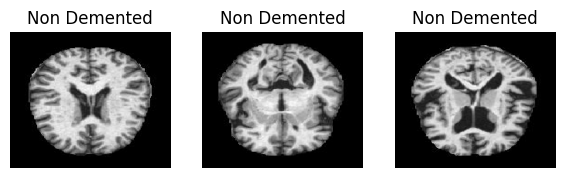

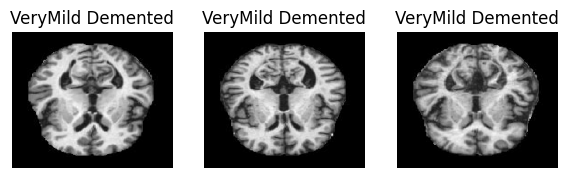

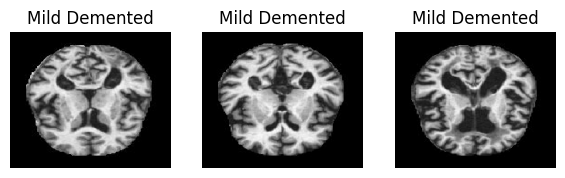

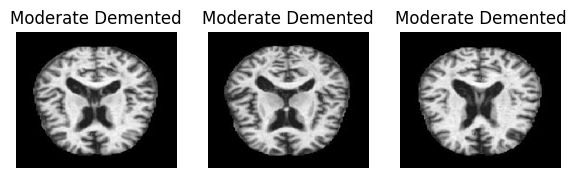

<Figure size 640x480 with 0 Axes>

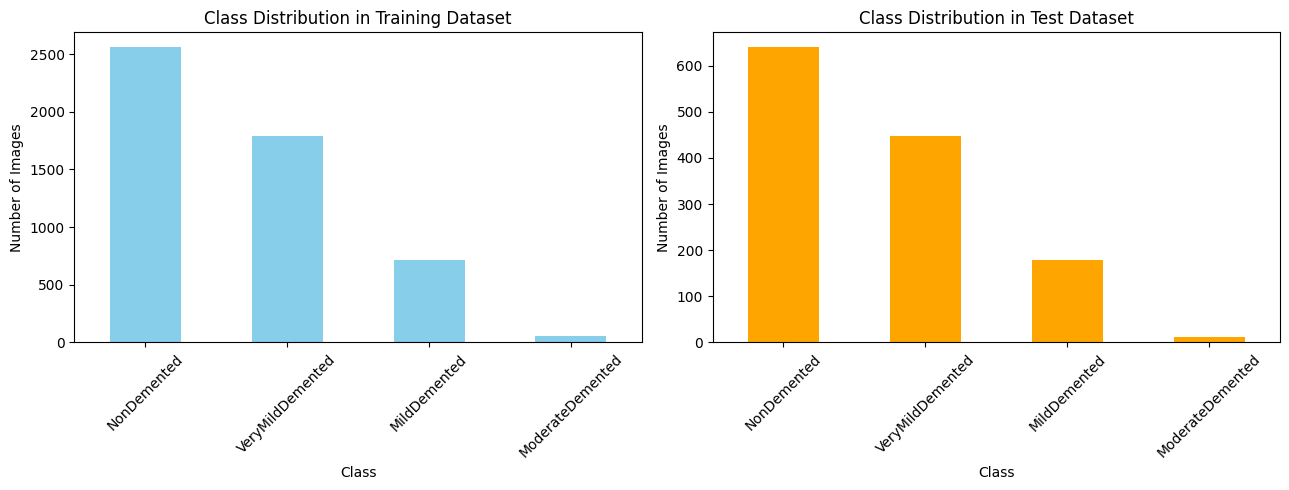

╒══════════════════╤═══════════════╤════════════════════════╤══════════════╤═══════════════════════╕
│ Class            │   Train Count │   Train Proportion (%) │   Test Count │   Test Proportion (%) │
╞══════════════════╪═══════════════╪════════════════════════╪══════════════╪═══════════════════════╡
│ ModerateDemented │            52 │                1.01543 │           12 │              0.938233 │
├──────────────────┼───────────────┼────────────────────────┼──────────────┼───────────────────────┤
│ NonDemented      │          2560 │               49.9902  │          640 │             50.0391   │
├──────────────────┼───────────────┼────────────────────────┼──────────────┼───────────────────────┤
│ MildDemented     │           717 │               14.0012  │          179 │             13.9953   │
├──────────────────┼───────────────┼────────────────────────┼──────────────┼───────────────────────┤
│ VeryMildDemented │          1792 │               34.9932  │          448 │             35

In [ ]:
# @title EDA
classes = os.listdir(train_dir)
desired_order = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]

for class_name in desired_order:
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)[:3]  # Get the first 3 images

    plt.figure(figsize=(12, 6))
    for i, image_name in enumerate(images):
        image_path = os.path.join(class_dir, image_name)
        img = load_img(image_path, target_size=(176, 208))
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name.replace("Demented", " Demented"))
        plt.axis('off')
    plt.show()

plt.subplots_adjust(hspace=2.0)

# Counts training data
train_class_counts = {}
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    train_class_counts[class_name] = len(os.listdir(class_dir))

# Counts test data
test_class_counts = {}
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    test_class_counts[class_name] = len(os.listdir(class_dir))

train_counts_df = pd.DataFrame.from_dict(train_class_counts, orient='index', columns=['Count'])
test_counts_df = pd.DataFrame.from_dict(test_class_counts, orient='index', columns=['Count'])

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=False)

# Training data distribution
train_counts_df.sort_values(by='Count', ascending=False).plot(
    kind='bar', ax=axes[0], legend=False, color='skyblue'
)
axes[0].set_title("Class Distribution in Training Dataset")
axes[0].set_ylabel("Number of Images")
axes[0].set_xlabel("Class")
axes[0].tick_params(axis='x', rotation=45)

# Test data distribution
test_counts_df.sort_values(by='Count', ascending=False).plot(
    kind='bar', ax=axes[1], legend=False, color='orange'
)
axes[1].set_title("Class Distribution in Test Dataset")
axes[1].set_ylabel("Number of Images")
axes[1].set_xlabel("Class")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


train_df = pd.DataFrame.from_dict(train_class_counts, orient='index', columns=['Train Count'])
test_df = pd.DataFrame.from_dict(test_class_counts, orient='index', columns=['Test Count'])
train_total = train_df['Train Count'].sum()
test_total = test_df['Test Count'].sum()

train_df['Train Proportion (%)'] = (train_df['Train Count'] / train_total) * 100
test_df['Test Proportion (%)'] = (test_df['Test Count'] / test_total) * 100

class_proportions_df = pd.concat([train_df, test_df], axis=1).fillna(0)

table = tabulate(
    class_proportions_df.reset_index(),
    headers=["Class", "Train Count", "Train Proportion (%)", "Test Count", "Test Proportion (%)"],
    tablefmt="fancy_grid",
    showindex=False
)
print(table)


# Pre-Trained Modeling

## ResNet 50


*   Widely used for multi-class classification tasks
*   ResNet50 is pretrained on ImageNet, which takes input images of size 224 x 224 x 3
*   Mitigates the vanishing gradient problem through skip connections





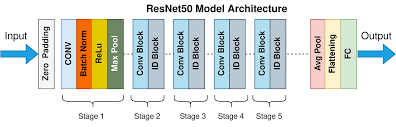

In [ ]:
# @title ResNet50
def preprocess_for_resnet(image, label):
    image = tf.image.resize(image, (224, 224))
    image = preprocess_input(image)
    return image, label

train_ds = train_dataset.map(preprocess_for_resnet)
val_ds = validation_dataset.map(preprocess_for_resnet)
test_ds = test_dataset.map(preprocess_for_resnet)
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Image batch shape: (32, 224, 224, 3)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1154s 9s/step - accuracy: 0.4514 - loss: 1.2734 - val_accuracy: 0.3896 - val_loss: 1.0736
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1104s 9s/step - accuracy: 0.5288 - loss: 0.9789 - val_accuracy: 0.4814 - val_loss: 0.9482
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1119s 8s/step - accuracy: 0.5530 - loss: 0.9060 - val_accuracy: 0.5928 - val_loss: 0.9350
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1062s 8s/step - accuracy: 0.5555 - loss: 0.8920 - val_accuracy: 0.4971 - val_loss: 0.9291
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 1104s 8s/step - accuracy: 0.5745 - loss: 0.8674 - val_accuracy: 0.7109 - val_loss: 0.7867
40/40 ━━━━━━━━━━━━━━━━━━━━ 268s 7s/step - accuracy: 0.3954 - loss: 1.2678
Test Accuracy: 56.76%


40/40 ━━━━━━━━━━━━━━━━━━━━ 268s 7s/step
Found 1279 files belonging to 4 classes.
Class Names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


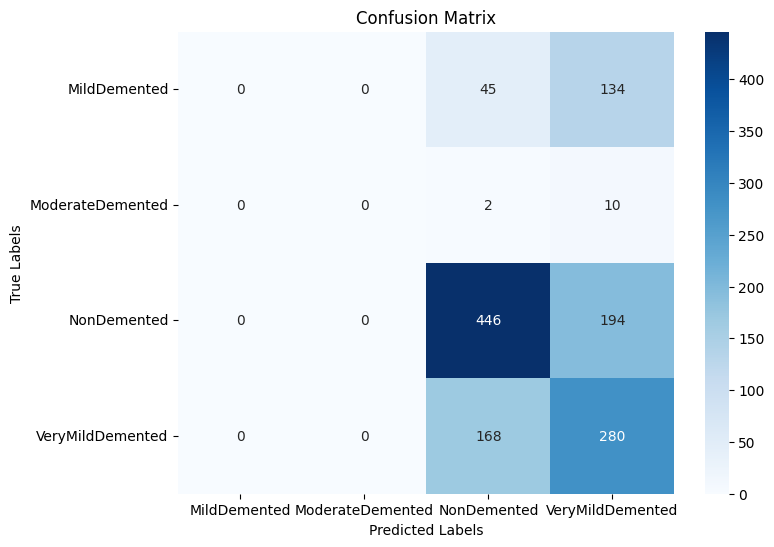

In [ ]:
# @title ResNet50 Confusion Matrix
# Step 1: Get true labels and predictions
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

original_test_ds = image_dataset_from_directory(
    '/content/ga_project_4/data/Alzheimer_s Dataset/test',
    labels="inferred",
    label_mode="categorical",
    image_size=(176, 208),
    batch_size=32,
    color_mode="grayscale",
    seed=42,
    shuffle=False
)


class_names = original_test_ds.class_names
print("Class Names:", class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



*   The model may not handle certain classes well, particularly Mild Demented and Moderate Demented
*   Significant confusion exists between 'Non-Demented' and 'Very Mild Demented'
*   Model may overfit to dominant classes or lacks sufficient complexity to generalize to minority classes




## DenseNet-121
* Primarily used for image classification and feature extraction
* Is pretrained on ImageNet, which takes input images of size 224 x 224 x 3
* Uses dense connections to ensure maximum information flow between layers by concatenating outputs of all preceding layers
* 121 layers consisting of an initial convolution, four dense blocks with transition layers, global average pooling, and a fully connected classification layer

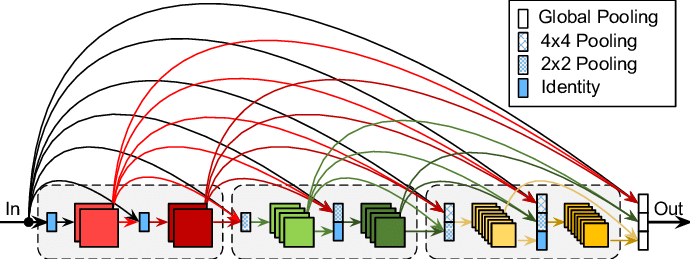

In [ ]:
# @title DenseNet-121
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def preprocess_and_convert_to_rgb(image, label):
    # Check the number of channels and ensure consistent shape
    image = tf.cond(
        tf.shape(image)[-1] != 1,
        lambda: tf.image.rgb_to_grayscale(image),  # Convert RGB to grayscale if necessary
        lambda: image
    )
    image = tf.image.resize(image, (128, 128))      # Resize to 128x128
    image = tf.image.grayscale_to_rgb(image)        # Convert grayscale to RGB (3 channels)
    return image, label

# Apply preprocessing using .map()
train_ds_RGB = train_dataset.map(preprocess_and_convert_to_rgb).shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_RGB = validation_dataset.map(preprocess_and_convert_to_rgb).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_RGB = test_dataset.map(preprocess_and_convert_to_rgb).prefetch(buffer_size=tf.data.AUTOTUNE)

# Load pre-trained DenseNet-121 without top layers and add custom layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model layers

# Build the model
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)  # 4 output classes
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds_RGB, validation_data=val_ds_RGB, epochs=5)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds_RGB)
print(f"Test Accuracy: {accuracy:.2f}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.4216 - loss: 7.3478 - val_accuracy: 0.2393 - val_loss: 2.1731
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.3942 - loss: 6.3382 - val_accuracy: 0.1992 - val_loss: 2.6689
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.3917 - loss: 5.8112 - val_accuracy: 0.2559 - val_loss: 2.2778
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.4415 - loss: 5.0647 - val_accuracy: 0.1543 - val_loss: 3.0518
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.4243 - loss: 4.9698 - val_accuracy: 0.2910 - val_loss: 2.0783
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.4411 - loss: 3.1590
Test Accuracy: 0.52


40/40 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step


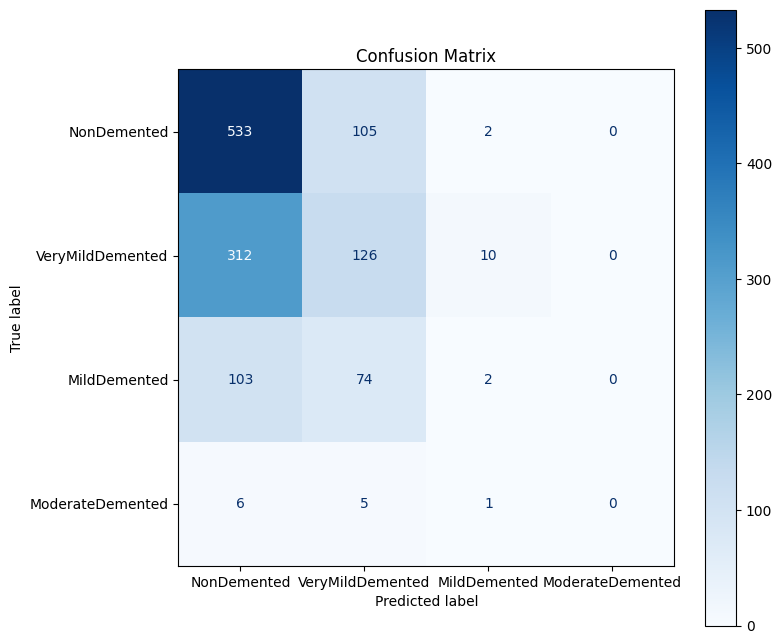

In [ ]:
# @title DenseNet-121 Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Define the desired order of labels
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Get true labels and predicted labels
y_true = np.concatenate([y for x, y in test_ds_RGB], axis=0).argmax(axis=1)
y_pred = model.predict(test_ds_RGB).argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Reorder the confusion matrix according to the desired label order
index_mapping = [2, 3, 0, 1]  # Indices corresponding to the new order of class_names
cm_reordered = cm[np.ix_(index_mapping, index_mapping)]

# Plot reordered confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reordered, display_labels=class_names)
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

* Performs well on majority classes (NonDemented and VeryMildDemented) but struggles with minority classes (MildDemented and ModerateDemented), indicating bias towards majority classes due to class imbalance
* MildDemented and ModerateDemented are often misclassified as NonDemented or VeryMildDemented, showing poor sensitivity for these minority classes

### Optimizing DenseNet-121
* Imbalanced classes in the dataset cause the model to have a bias towards the NonDemented and VeryMildDemented classes
* Class weights are used to address the class imbalance and ensure the model gives more importance to the minority classes (MildDemented and ModerateDemented)
* Early stopping is used to prevent general overfitting by stopping training when the validation loss stops improving

In [ ]:
# @title DenseNet-121 - Class Imbalance
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def preprocess_and_convert_to_rgb(image, label):
    # Check the number of channels and ensure consistent shape
    image = tf.cond(
        tf.shape(image)[-1] != 1,
        lambda: tf.image.rgb_to_grayscale(image),  # Convert RGB to grayscale if necessary
        lambda: image
    )
    image = tf.image.resize(image, (128, 128))      # Resize to 128x128
    image = tf.image.grayscale_to_rgb(image)        # Convert grayscale to RGB (3 channels)
    return image, label

# Apply preprocessing using .map()
train_ds_RGB = train_dataset.map(preprocess_and_convert_to_rgb).shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_RGB = validation_dataset.map(preprocess_and_convert_to_rgb).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_RGB = test_dataset.map(preprocess_and_convert_to_rgb).prefetch(buffer_size=tf.data.AUTOTUNE)

# Extract class labels from the training dataset to compute class weights
train_labels = np.concatenate([labels.numpy().argmax(axis=1) for _, labels in train_ds_RGB], axis=0)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Load pre-trained DenseNet-121 without top layers and add custom layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model layers

# Build the model
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax')(x)  # 4 output classes
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=3,                # Stop training if no improvement after 3 epochs
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train the model with class weights and early stopping
history = model.fit(
    train_ds_RGB,
    validation_data=val_ds_RGB,
    epochs=5,                 # Allow up to 20 epochs, early stopping will prevent overfitting
    class_weight=class_weights,  # Apply class weights to handle imbalance
    callbacks=[early_stopping],  # Add early stopping callback
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds_RGB)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.2116 - loss: 9.4206 - val_accuracy: 0.0693 - val_loss: 3.2358
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.2446 - loss: 8.2303 - val_accuracy: 0.2168 - val_loss: 2.1999
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.2443 - loss: 8.1799 - val_accuracy: 0.1699 - val_loss: 2.7277
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.2629 - loss: 8.2300 - val_accuracy: 0.1523 - val_loss: 2.6048
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.2960 - loss: 7.4159 - val_accuracy: 0.2354 - val_loss: 2.1425
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.5374 - loss: 1.5869
Test Accuracy: 0.43


40/40 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step


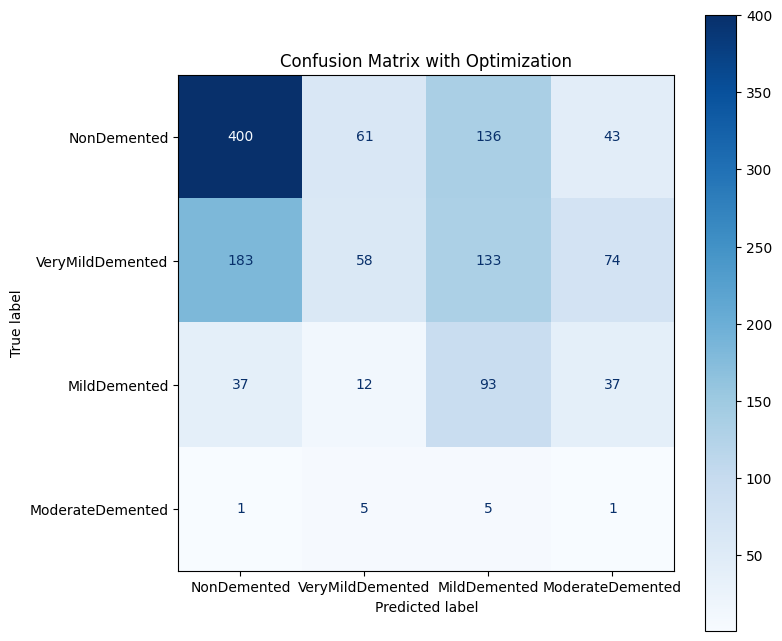

In [ ]:
# @title Optimized DenseNet-121 Confusion Matrix
# Define the desired order of labels
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Get true labels
y_true = np.concatenate([y.numpy().argmax(axis=1) for _, y in test_ds_RGB], axis=0)

# Get predicted labels in one go
y_pred = model.predict(test_ds_RGB).argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Reorder the confusion matrix according to the desired label order
index_mapping = [2, 3, 0, 1]  # Indices corresponding to the new order of class_names
cm_reordered = cm[np.ix_(index_mapping, index_mapping)]

# Plot reordered confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reordered, display_labels=class_names)
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix with Optimization')
plt.show()

* Improved classification of minority classes causing a reduced misclassification for MildDemented and slight improvement for classification of ModerateDemented
* VeryMildDemented shows considerable confusion with NonDemented
* Bias towards majority classes remains

### DenseNet-121 Augmented Data
* Artificially increase the size and diversity of a dataset by applying various transformations (e.g., flipping, rotation, scaling) to the training images
* Reduces overfitting
* Improves minority class performance

In [ ]:
# @title DenseNet-121 Augmented Data
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

def augment_mild_moderate(image, label):
    # Get the class index for each image in the batch
    class_indices = tf.argmax(label, axis=-1)  # Shape: (batch_size,)

    # Function to apply augmentation to a single image
    def apply_augmentation(img, idx):
        img = tf.expand_dims(img, axis=0)  # Expand dims to create batch-like input
        img = data_augmentation(img)  # Apply augmentation
        return tf.squeeze(img, axis=0)  # Remove the added batch dimension

    # Apply augmentation only to "Mild Demented" (1) and "Moderate Demented" (2)
    augmented_images = tf.map_fn(
        lambda img_and_idx: tf.cond(
            tf.logical_or(
                tf.equal(img_and_idx[1], 1),  # Mild Demented
                tf.equal(img_and_idx[1], 2)   # Moderate Demented
            ),
            lambda: apply_augmentation(img_and_idx[0], img_and_idx[1]),  # Apply augmentation
            lambda: img_and_idx[0]  # No augmentation
        ),
        (image, class_indices),
        fn_output_signature=tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32)
    )

    return augmented_images, label

# Apply augmentation using .map() for training dataset
train_ds_augmented = train_ds_RGB.map(augment_mild_moderate).shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Train the model using the augmented dataset
history = model.fit(train_ds_augmented, validation_data=val_ds_RGB, epochs=5)

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds_RGB)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.4928 - loss: 4.3756 - val_accuracy: 0.5889 - val_loss: 0.9452
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.5218 - loss: 3.8691 - val_accuracy: 0.8076 - val_loss: 0.4414
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step - accuracy: 0.5665 - loss: 3.2268 - val_accuracy: 0.9131 - val_loss: 0.2540
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.5964 - loss: 2.9570 - val_accuracy: 0.9189 - val_loss: 0.2279
Epoch 5/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.6125 - loss: 2.8475 - val_accuracy: 0.9150 - val_loss: 0.2419
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.3852 - loss: 2.6735
Test Accuracy: 0.54


40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step


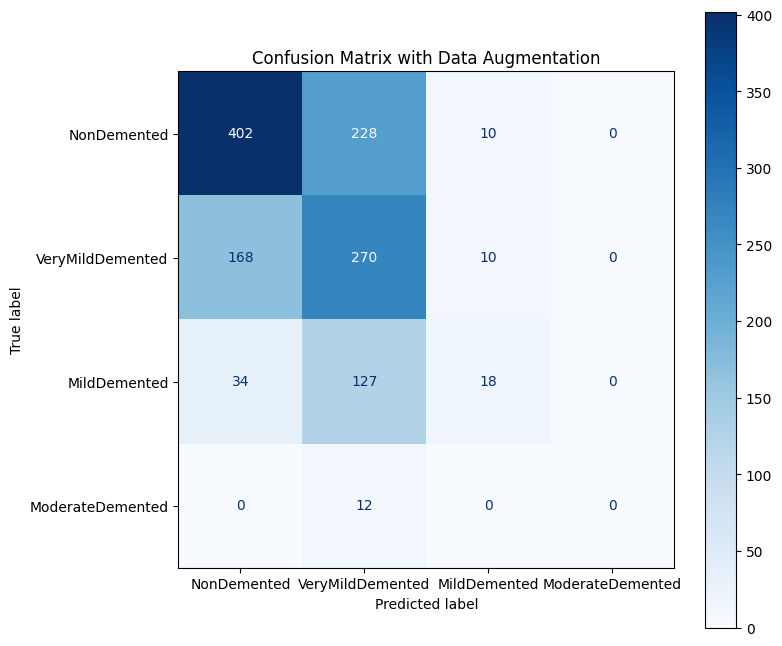

In [ ]:
# @title DenseNet-121 Augmented Data Confusion Matrix
# Define the desired order of labels
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Get true labels and predicted labels for the augmented model
y_true = np.concatenate([y for x, y in test_ds_RGB], axis=0).argmax(axis=1)
y_pred_augmented = model.predict(test_ds_RGB).argmax(axis=1)

# Compute confusion matrix
cm_augmented = confusion_matrix(y_true, y_pred_augmented)

# Reorder the confusion matrix according to the desired label order
index_mapping = [2, 3, 0, 1]  # Indices corresponding to the new order of class_names
cm_reordered_augmented = cm_augmented[np.ix_(index_mapping, index_mapping)]

# Plot reordered confusion matrix for the augmented model
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reordered_augmented, display_labels=class_names)
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix with Data Augmentation')
plt.show()

* Continued confusion between NonDemented and VeryMildDemented
* Very poor performance for ModerateDemented, with no correct predictions for this class
* Bias towards majority classes remains

## MobileNet



*   Designed for mobile and embedded devices --> smaller and more efficient
*   Uses Depthwise Separable Convolutions to reduce computational cost



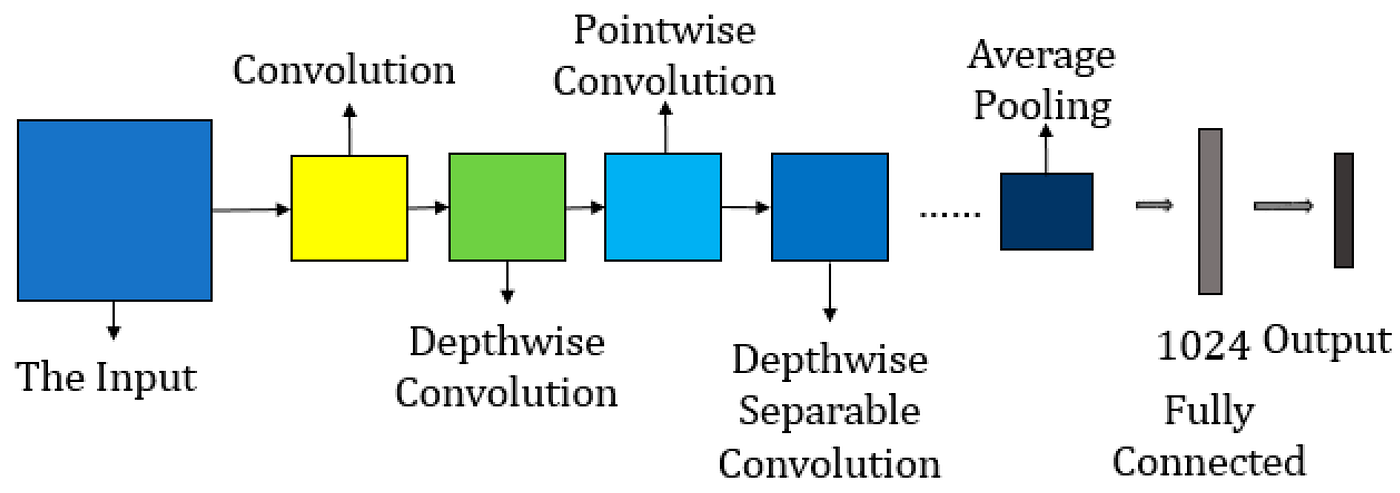

In [ ]:
# @title MobileNet

import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input

def preprocess_for_mobilenet(image, label):
    image = tf.image.resize(image, (128, 128))
    image = preprocess_input(image)
    return image, label

train_ds = train_dataset.map(preprocess_for_mobilenet)
val_ds = validation_dataset.map(preprocess_for_mobilenet)
test_ds = test_dataset.map(preprocess_for_mobilenet)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.4699 - loss: 1.2766 - val_accuracy: 0.6045 - val_loss: 0.9001
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5599 - loss: 0.9047 - val_accuracy: 0.5186 - val_loss: 0.9207
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5983 - loss: 0.8552 - val_accuracy: 0.4043 - val_loss: 1.0738
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6173 - loss: 0.8270 - val_accuracy: 0.6904 - val_loss: 0.8007
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6309 - loss: 0.7932 - val_accuracy: 0.6865 - val_loss: 0.7443
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6488 - loss: 0.7760 - val_accuracy: 0.6045 - val_loss: 0.8425
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6738 - loss: 0.7287 - val_accuracy: 0.6436 - val_loss: 0.7720
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6691 - loss: 0.7159 - val_acc

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step
Class Names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


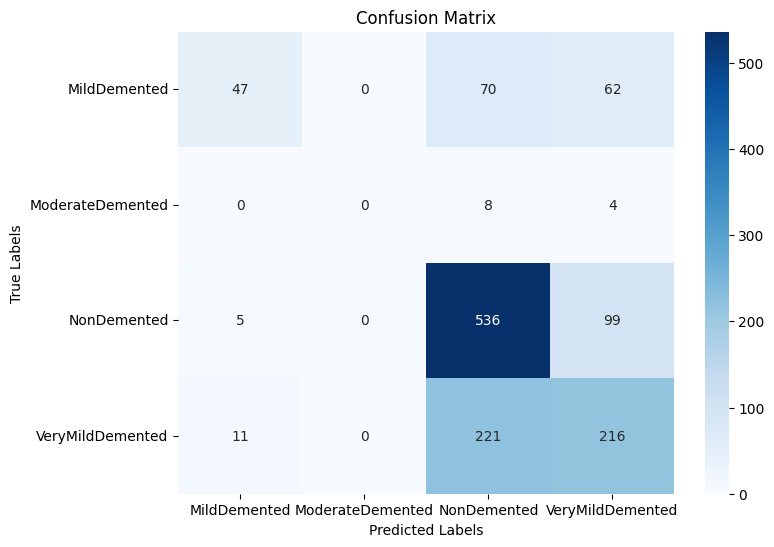

In [ ]:
# @title MobileNet Confusion Matrix
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

class_names = test_dataset.class_names
print("Class Names:", class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



*   The model struggles to distinguish "Mild Demented" and "Moderate Demented" from other classes
*   No cases of moderate dementia were predicted correctly
*   Predicted as "NonDemented" cases well (over 500 correct) --> overall bias towards the majority class





### Optimizing MobileNet

*   Imbalanced datasets (e.g., more "NonDemented" samples) can lead the model to prioritize the dominant classes while neglecting others
*   Using class weights gives higher importance to underrepresented classes by ensuring that the model pays more attention to underrepresented classes during training
*   Early stopping prevents the model from overfitting to the more heavily weighted classes




In [ ]:
# @title MobileNet - Class Weighting
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping


train_labels = [label.numpy().argmax() for _, labels in train_dataset for label in labels]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5701 - loss: 0.7656 - val_accuracy: 0.7314 - val_loss: 0.6923
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5558 - loss: 0.7473 - val_accuracy: 0.5713 - val_loss: 0.9329
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5569 - loss: 0.7725 - val_accuracy: 0.5322 - val_loss: 0.9740
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5069 - loss: 0.9131 - val_accuracy: 0.5303 - val_loss: 0.8989
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4876 - loss: 1.0579
Test Accuracy: 57.31%


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Class Names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


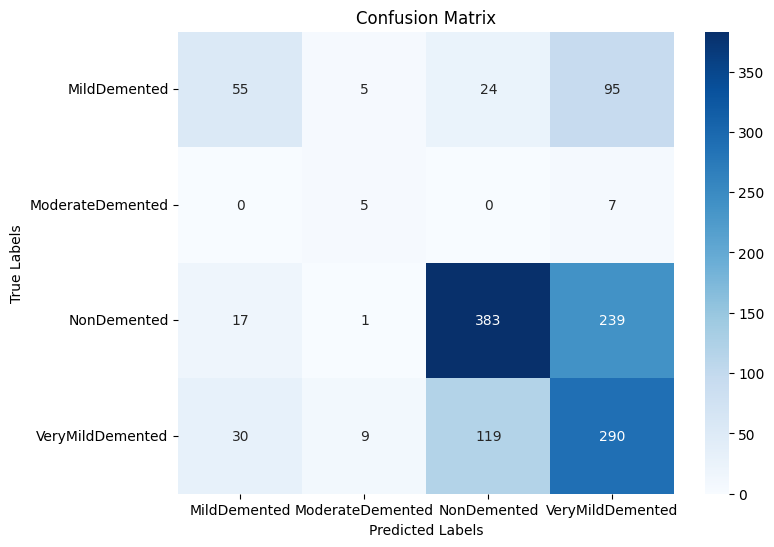

In [ ]:
# @title MobileNet (Class Weighting) Confusion Matrix
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

class_names = test_dataset.class_names
print("Class Names:", class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



*   Lower overall accuracy
*   Recall for "Mild Demented" improved slightly and there are few correct predictions for "Moderate Demented"
*   Higher misclassification rates compared to earlier results for "NonDemented"
*   Improved performance for the “VeryMildDemented” class





In [ ]:
# @title MobileNet - Data Augmentation
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

AUTOTUNE = tf.data.AUTOTUNE

def preprocess_for_mobilenet(image, label):
    image = tf.image.resize(image, (128, 128))
    image = preprocess_input(image)
    return image, label


def augment_data(image, label):
    # Check if the label corresponds to Mild Demented (2) or Moderate Demented (3)
    class_index = tf.argmax(label, axis=-1)
    class_condition = tf.reduce_any(tf.equal(class_index, 2)) | tf.reduce_any(tf.equal(class_index, 3))


    def augment_image():
        image_aug = tf.image.flip_left_right(image)
        image_aug = tf.image.rot90(image_aug)
        image_aug = tf.image.random_brightness(image_aug, max_delta=0.2)
        return image_aug


    image = tf.cond(class_condition, lambda: augment_image(), lambda: image)
    return image, label


train_ds = train_dataset.map(preprocess_for_mobilenet)
train_ds_augmented = train_ds.map(augment_data).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

val_ds = validation_dataset.map(preprocess_for_mobilenet).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.map(preprocess_for_mobilenet).cache().prefetch(buffer_size=AUTOTUNE)


train_labels = [label.numpy().argmax() for _, labels in train_dataset for label in labels]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

base_model = MobileNet(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


history = model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)


test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")




Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 92s 549ms/step - accuracy: 0.3352 - loss: 1.8767 - val_accuracy: 0.1250 - val_loss: 1.3742
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 122s 490ms/step - accuracy: 0.4217 - loss: 1.1716 - val_accuracy: 0.5693 - val_loss: 1.0003
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 79s 465ms/step - accuracy: 0.4406 - loss: 1.1035 - val_accuracy: 0.2178 - val_loss: 1.2328
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 83s 475ms/step - accuracy: 0.4486 - loss: 1.0627 - val_accuracy: 0.1689 - val_loss: 1.1683
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 81s 471ms/step - accuracy: 0.4831 - loss: 0.9934 - val_accuracy: 0.1553 - val_loss: 1.2077
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 394ms/step - accuracy: 0.4171 - loss: 1.2349
Test Accuracy: 53.56%


40/40 ━━━━━━━━━━━━━━━━━━━━ 17s 403ms/step
Class Names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


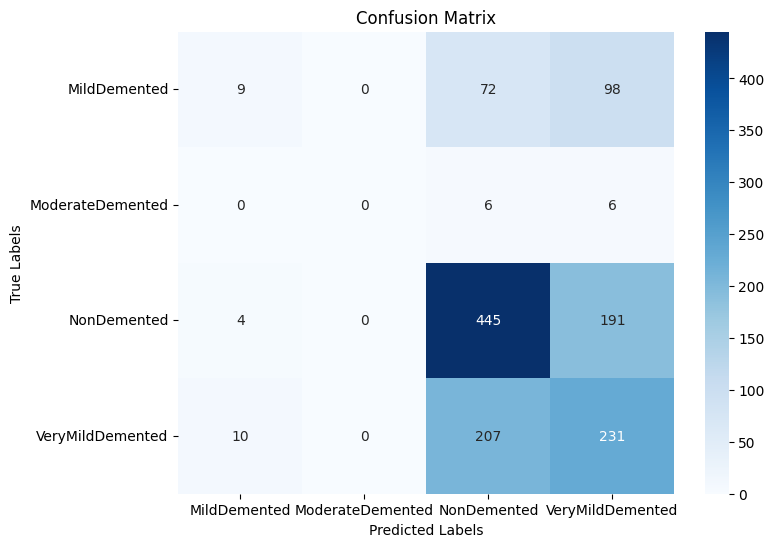

In [ ]:
# @title MobileNet (Augmented Data) Confusion Matrix
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

class_names = test_dataset.class_names
print("Class Names:", class_names)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



*   Lower overall accurary
*   Despite augmentation, the model struggles to predict "Mild Demented" accurately
*   Even with augmentation, the model fails to improve predictions for "Moderate Demented"
*   High overlap features between "Very Mild Demented" and “NonDemented” classes





## EfficientNet-B1
* Primarily used for image classification, feature extraction, and transfer learning
* Pretrained on ImageNet, with input image size of 240 x 240 x 3 for EfficientNet-B1
* 242-layer architecture built with MBConv blocks, combining depthwise separable convolutions and squeeze-and-excitation layers for efficient feature learning

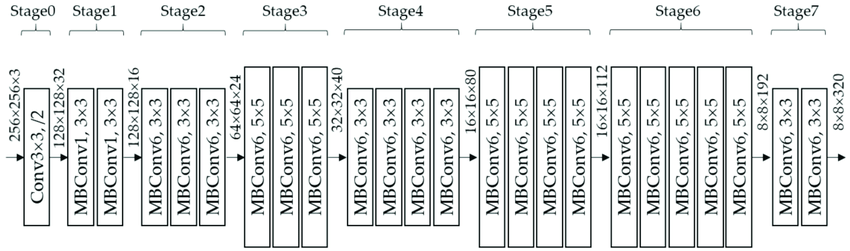

In [ ]:
# @title EfficientNet-B1
# if there is time this code can be run in this doc but if not there are pictures of the outputs
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Step 1: Preprocess dataset using preprocess_input for EfficientNet
def preprocess_dataset(dataset):
    return dataset.map(lambda x, y: (preprocess_input(x), y))

train_dataset = preprocess_dataset(train_dataset)
validation_dataset = preprocess_dataset(validation_dataset)
test_dataset = preprocess_dataset(test_dataset)

# Step 2: Load pre-trained EfficientNet-B1 without top layers
base_model = EfficientNetB1(
    weights="imagenet",
    include_top=False,
    input_shape=(176, 208, 3)
)

# Step 3: Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)  # Apply Dense layer on 'x'
model = Model(inputs=base_model.input, outputs=output)

# Step 4: Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Step 5: Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

# Step 6: Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

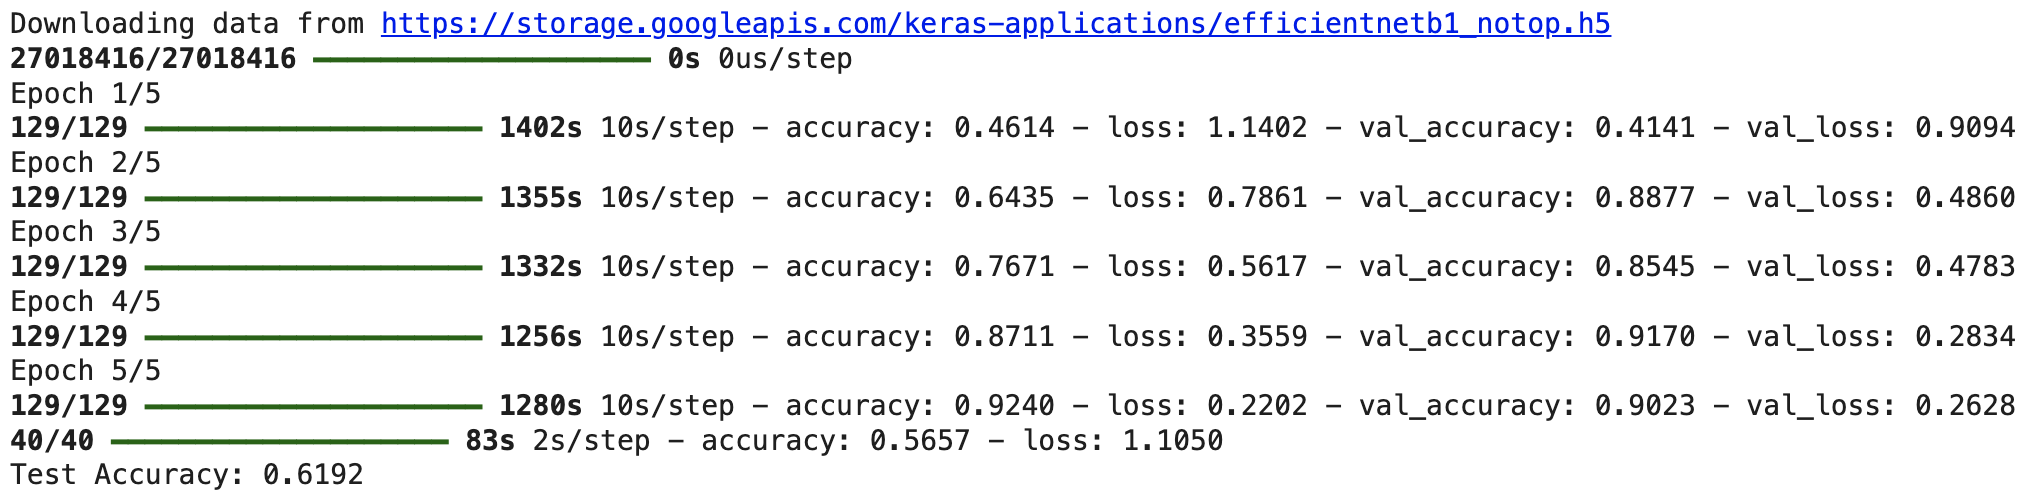

In [ ]:
# @title EfficientNet-B1 Confusion Matrix
# if there is time this code can be run in this doc but if not there are pictures of the outputs
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Define the desired order of labels
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Get true labels and predicted labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0).argmax(axis=1)
y_pred = model.predict(test_dataset).argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Reorder the confusion matrix according to the desired label order
index_mapping = [2, 3, 0, 1]
cm_reordered = cm[np.ix_(index_mapping, index_mapping)]

# Plot reordered confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reordered, display_labels=class_names)
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

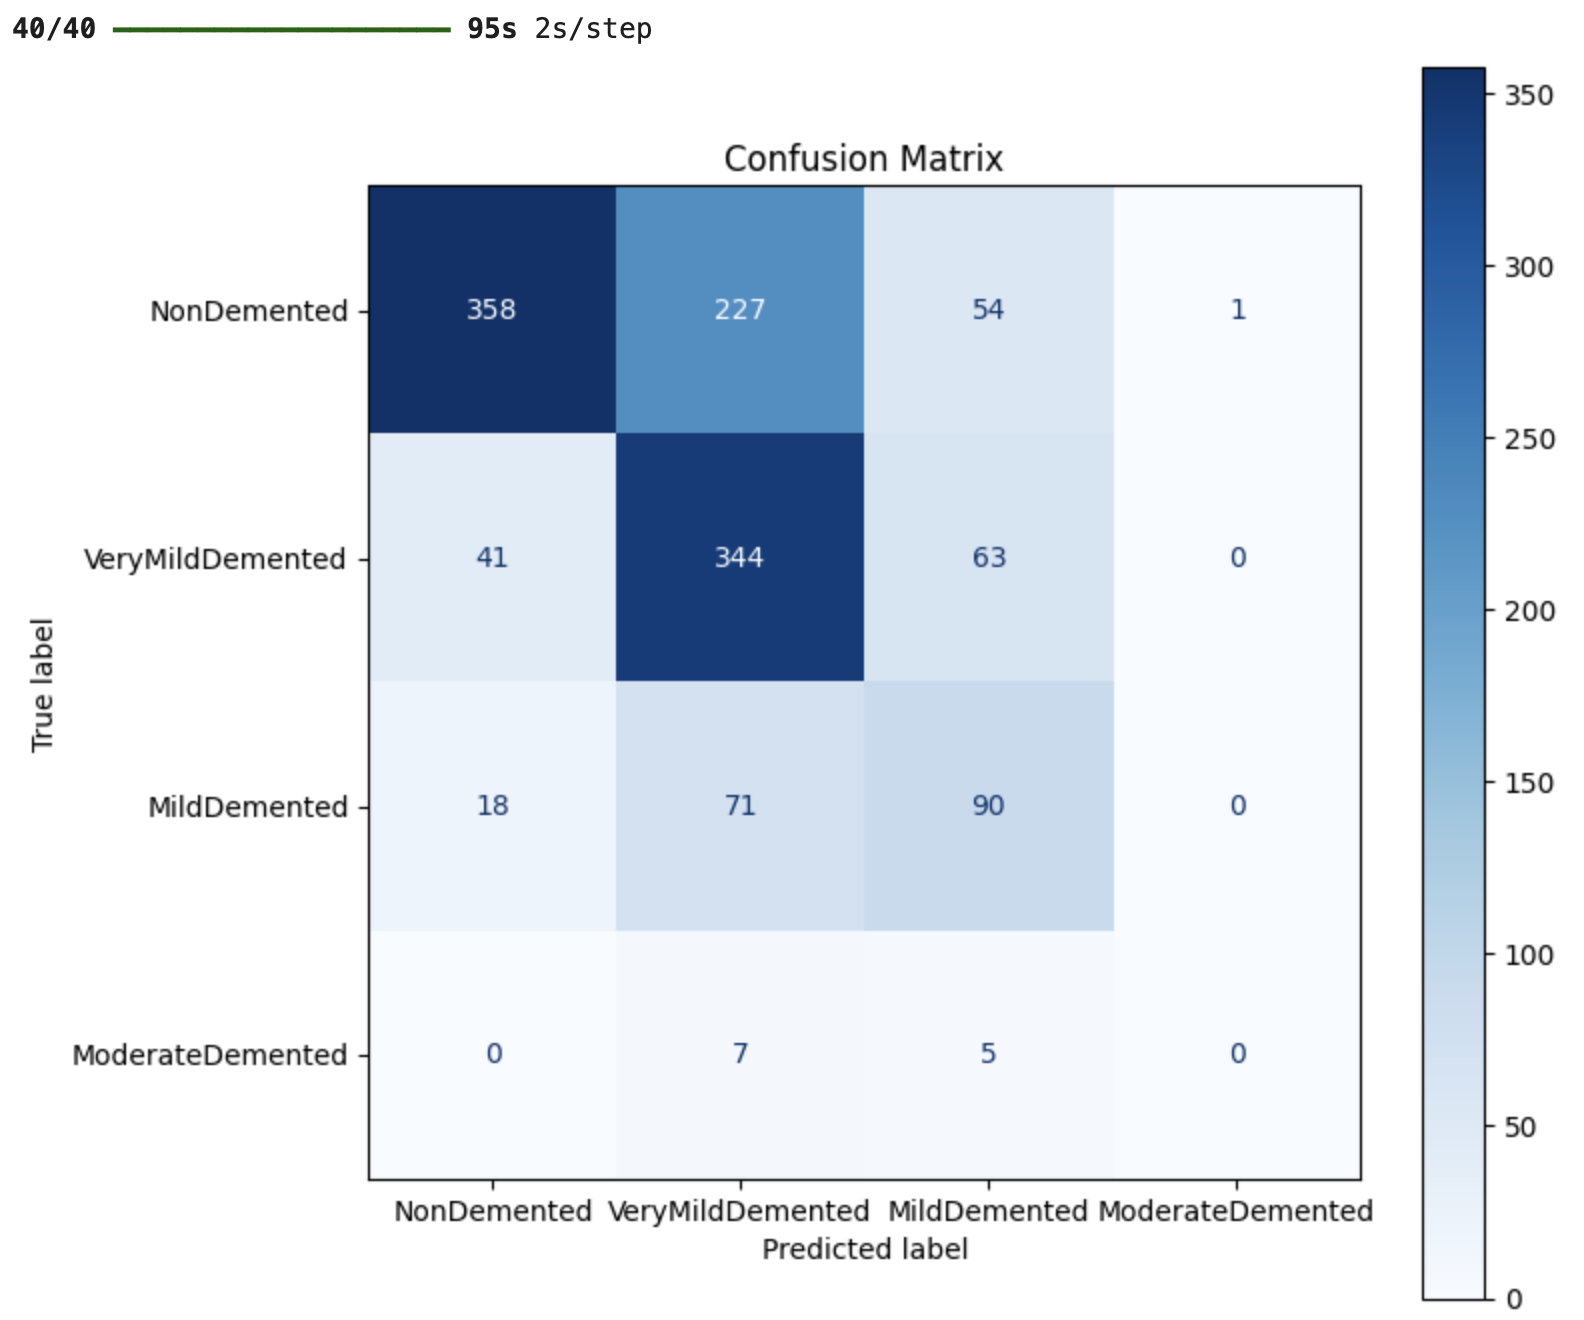

* Improved classification for majority classes
* MildDemented shows moderate performance
* Poor performance for ModerateDemented
* Reduced misclassification across classes

# Limitations
* Class imbalance with a very small sample size for minority classes
* Lack of additional data with MRI images
* Limited data augmentation

# Conclusion


*   The original MobileNet (62%) and EfficientNet (61%) models produce the highest accuracy, but do not meet 80% accuracy goal
*   Models are better at classifying “NonDemented” and “VeryMildDemented” classes, but detailed memory testing should be used for diagnosing Alzheimer’s dementia
### Final Question: Can MRI images be used to accurately classify different stages of cognitive impairment (Non-demented, Very Mild Demented, Mild Demented, and Moderate Demented) in Alzheimer's disease?


*   These MRI images do not seem to be able to accurately classify the stages of Alzheimer's disease




# Sources

* https://github.com/drossDS/ga_project_4/tree/main/data
* https://pmc.ncbi.nlm.nih.gov/articles/PMC10178535/
* https://www.frontiersin.org/journals/neuroscience/articles/10.3389/fnins.2018.00777/full
* https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0173372
* https://medium.com/@shamimmahbub230/densenet121-model-implementation-7c403c7e521b
* https://www.researchgate.net/figure/Structure-of-EfficientNet-B1_fig2_347801324
*   https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758
*   https://www.mayoclinic.org/diseases-conditions/alzheimers-disease/in-depth/alzheimers/art-20048075#:~:text=You%20may%20need%20lab%20tests,conditions%20that%20cause%20similar%20symptoms.
*   https://www.nm.org/healthbeat/medical-advances/How-Is-Alzheimers-Disease-Diagnosed#:~:text=Diagnosing%20Alzheimer's%20Disease%20Earlier,remain%20the%20most%20definitive%20test.
*   https://medium.com/@godeep48/an-overview-on-mobilenet-an-efficient-mobile-vision-cnn-f301141db94d
*   https://www.nia.nih.gov/health/alzheimers-and-dementia/alzheimers-disease-fact-sheet





